In [2]:
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np

In [6]:
img_rows = 32
img_cols = 32
channels = 3
img_shape = (img_rows, img_cols, channels)
num_classes = 10
latent_dim = 128
(x_train, y_train),(x_test, y_test) = keras.datasets.cifar10.load_data()

In [7]:
# Generator

# Input layers setup [one for noise and one for class label]
noise = keras.layers.Input(shape=(latent_dim,))
label = keras.layers.Input(shape=(1,), dtype='int32')
label_embedding = keras.layers.Flatten()(keras.layers.Embedding(num_classes, latent_dim)(label))
generator_input = keras.layers.Multiply()([noise, label_embedding])
#generator_input = noise
# Generation of hidden layer structures
generator_hidden = keras.layers.Dense(128 * 8 * 8, activation='gelu')(generator_input)
generator_hidden = keras.layers.Reshape((8, 8, 128))(generator_hidden)
generator_hidden = keras.layers.BatchNormalization(momentum=0.8)(generator_hidden)
generator_hidden = keras.layers.Conv2DTranspose(64, kernel_size=2, strides=2,
                                                activation='gelu')(generator_hidden)
generator_hidden = keras.layers.BatchNormalization(momentum=0.8)(generator_hidden)
generator_hidden = keras.layers.Conv2DTranspose(32, kernel_size=2, strides=2,
                                                activation='gelu')(generator_hidden)
generator_hidden = keras.layers.BatchNormalization(momentum=0.8)(generator_hidden)
g_image = keras.layers.Conv2DTranspose(channels, kernel_size=3,
                                       padding='same', activation='tanh')(generator_hidden)

# Finalize the model
generator = keras.Model([noise, label], g_image)
#generator = keras.Model([noise], g_image)
generator.compile(loss=keras.losses.BinaryCrossentropy(),
                  optimizer=keras.optimizers.Adam(0.0001,0.9))

In [8]:
# Discriminator

class PositionEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, embed_dim):
        super(PositionEmbedding, self).__init__()
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-2] # x already embedded
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions
    

patch_size = 8
embed_dim = 256
num_heads = 12
ff_dim = 1024
stack = 12


x = keras.layers.Input(shape=x_train.shape[1:])
y = x
    
y = keras.layers.Conv2D(embed_dim,
                            kernel_size=(patch_size),
                            strides=(patch_size,patch_size))(y)
y = keras.layers.Reshape((-1,embed_dim))(y)
    
c = keras.layers.Lambda(lambda x: tf.tile(tf.constant([[[0.0]]]),
                                             (tf.shape(x)[0],1,embed_dim)))(x)
y = keras.layers.Concatenate(axis=1)([c,y])
 
y = PositionEmbedding(y.shape[1],embed_dim)(y)
    
for _ in range(stack):
    y = TransformerBlock(embed_dim,num_heads,ff_dim)(y)
    
y = keras.layers.Lambda(lambda x: x[:,0,:])(y)
    
y = keras.layers.Dense(ff_dim)(y)
y = keras.layers.LayerNormalization()(y)
y = keras.layers.Activation(activation=keras.activations.gelu)(y)
    
y = keras.layers.Dense(len(np.unique(y_train)))(y)

# Outputs will be both a probability of being "real" and...
valid = keras.layers.Dense(1, activation='sigmoid')(y)
# A probability of what class (with fakes having a unique class (+1))
target_label = keras.layers.Dense(num_classes+1,
                                  activation='softmax')(y)
# Finalize the model
discriminator = keras.Model(x, [valid, target_label])
discriminator.compile(loss=[keras.losses.BinaryCrossentropy(),
                            keras.losses.SparseCategoricalCrossentropy()],
                      optimizer=keras.optimizers.Adam(0.00002,0.5),
                      metrics=['accuracy'])


NameError: name 'TransformerBlock' is not defined

In [8]:
# Combined model...

# When training the generator, we need to pass through the discriminator...
# However, we don't want the discriminator to update during training
# of the generator (which would generate a -moving target- problem
# similar to RL agents)

# So, we will turn the discriminator training -off- when training with
# the combined model (combined model is really -only- used to train
# the generator even though it shares layers with the "trainable"
# discriminator that we made earlier)

# Turn off learning for generator...
discriminator.trainable = False

# Make the output of the generator feed into the discriminator.
# Note that we don't recompile the discriminator when doing this so that
# the discriminator can still be trained independently...
valid, target_label = discriminator(g_image) # g_image = generator output layer

# Combined model now takes generator inputs and has discriminator outputs...
combined = keras.Model([noise, label],[valid, target_label])
combined.compile(loss=[keras.losses.BinaryCrossentropy(),
                       keras.losses.SparseCategoricalCrossentropy()],
                 optimizer=keras.optimizers.Adam(0.0002,0.5))

In [9]:
# Training Parameters
history = [[],[],[],[]]
batch_size = 256
half_batch_size = int(batch_size/2)

In [15]:
generator.load_weights("cifar10_gan_weights.h5")

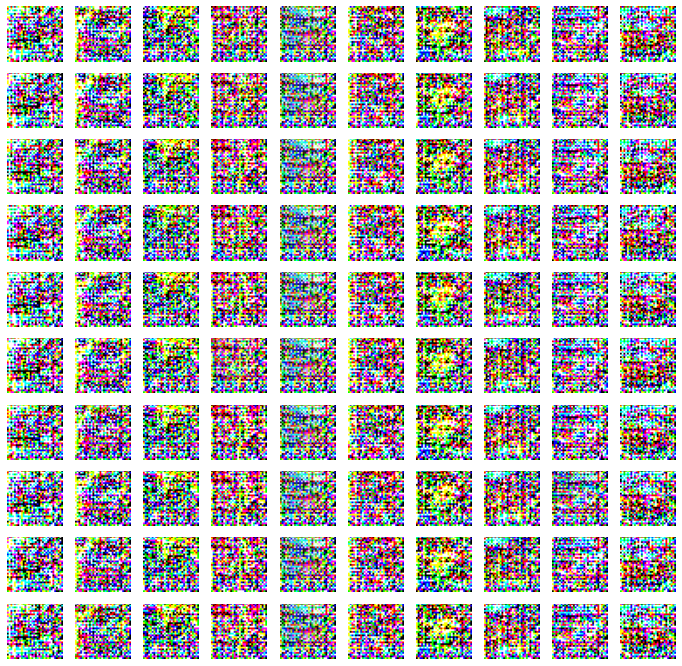

In [16]:
## Testing
r, c = 10, 10
noise = np.random.normal(0, 1, (r * c, latent_dim))
sampled_labels = np.array([num for _ in range(r) for num in range(c)])

# Make some fakes!
generated_images = generator.predict([noise, sampled_labels])
# Rescale images 0 - 1
generated_images = 0.5 * (generated_images + 1)

# Plot them...
fig, axs = plt.subplots(r, c)
fig.set_figwidth(12)
fig.set_figheight(12)
count = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(generated_images[count, :,:,:])
        axs[i,j].axis('off')
        count += 1
plt.show()